## Autoencoder

### Kiến trúc

Autoencoder là một kiến trúc mạng nơ-ron, trong đó một mạng con gọi là encoder sẽ nén đặc trưng của đối tượng thành một vector có kích thước nhỏ hơn (gọi là biểu diễn tiềm ẩn - latent representation), sau đó một mạng con khác gọi là decoder sẽ tái tạo lại vector đó về không gian đặc trưng ban đầu.

Chúng ta có thể sử dụng bất kỳ loại mạng nào cho encoder và decoder tùy thuộc vào loại dữ liệu: các lớp fully-connected, tích chập (convolutional), thậm chí cả tuần tự (recurrent).



In [15]:
import random
import numpy as np
from glob import glob
from PIL import Image
from collections import defaultdict

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.datasets import MNIST
from tbparse import SummaryReader


import matplotlib.pyplot as plt
import matplotlib_inline
plt.rcParams["figure.dpi"] = 150
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [32, 64, 128, 256]  # number of filters in layers
        modules = []
        in_channels = 1  # initial value of channels

        for h_dim in hidden_dims:  # convolutional layer
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channels,  # num of input channels
                        out_channels=h_dim,  # num of output channels
                        kernel_size=3,
                        stride=2,  # convolution kernel step
                        padding=1,  # save shape
                    ),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU(),
                )
            )
            in_channels = h_dim  # changing number of input channels for next iteration

        modules.append(nn.Flatten())  # to vector, size 256 * 2 * 2 = 1024
        modules.append(nn.Linear(256 * 2 * 2, latent_dim))

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [256, 128, 64, 32]  # number of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=1024)

        modules = []
        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2),
                    nn.Conv2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=5),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x)  # from latents space to Linear
        x = x.view(-1, 256, 2, 2)  # reshape
        x = self.decoder(x)  # reconstruction
        return x

Hãy xem kiến trúc với dữ liệu đầu vào có kích thước `(1, 28, 28)` và kích thước biểu diễn ẩn là `latent_dim = 2`:

In [5]:
from torchsummary import summary

latent_dim = 2

encoder = Encoder(latent_dim=latent_dim)
print(">>> Encoder")
print(summary(encoder, (1, 28, 28), device="cpu"))

decoder = Decoder(latent_dim=latent_dim)
print(">>> Decoder")
print(summary(decoder, (1, latent_dim), device="cpu"))

>>> Encoder
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 14, 14]             320
       BatchNorm2d-2           [-1, 32, 14, 14]              64
         LeakyReLU-3           [-1, 32, 14, 14]               0
            Conv2d-4             [-1, 64, 7, 7]          18,496
       BatchNorm2d-5             [-1, 64, 7, 7]             128
         LeakyReLU-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 4, 4]          73,856
       BatchNorm2d-8            [-1, 128, 4, 4]             256
         LeakyReLU-9            [-1, 128, 4, 4]               0
           Conv2d-10            [-1, 256, 2, 2]         295,168
      BatchNorm2d-11            [-1, 256, 2, 2]             512
        LeakyReLU-12            [-1, 256, 2, 2]               0
          Flatten-13                 [-1, 1024]               0
           Linear-14       

### Huấn luyện

Huấn luyện autoencoder, sử dụng framework Lightning.

Hai phương thức chính cần chú ý là `forward_handler` và `loss_handler`. Trong các phương thức này sẽ xác định cách dữ liệu đi qua autoencoder và cách tính hàm mất mát.

Trong trường hợp autoencoder đơn giản, quy trình như sau:

* Trong `forward_handler`, khi dữ liệu đi qua autoencoder, trước tiên encoder chuyển dữ liệu sang biểu diễn tiềm ẩn:

  `latent = self.encoder(data)`
  
  Sau đó decoder tái tạo lại dữ liệu từ biểu diễn tiềm ẩn:

  `recon = self.decoder(latent)`

* Trong `loss_handler`, hàm mất mát là entropy chéo nhị phân (binary cross-entropy), hoặc ở đây là sai số bình phương trung bình (MSE) giữa đầu vào và đầu ra được tái tạo:

  `loss = F.mse_loss(recon, data)`

Khi kiểm tra mô hình, sẽ tạo một dictionary `self.test_result` chứa 4 khóa: `real`, `recon`, `latent` và `labels`, tương ứng với:
- dữ liệu đầu vào thực,
- dữ liệu được tái tạo,
- biểu diễn tiềm ẩn,
- và nhãn lớp.

Hai phương thức `reset_test_result` và `update_test_result` giúp tạo và cập nhật dictionary kết quả này.


In [ ]:
class LitAE(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def forward_handler(self, data, *args, **kwargs):
        # here is the logic how data is moved through AE
        latent = self.encoder(data)
        recon = self.decoder(latent)
        return latent, recon

    def loss_handler(self, recon, data, *args, **kwargs):
        # here is the loss function computing
        loss = F.mse_loss(F.sigmoid(recon), data)
        return loss

    def training_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        loss = self.loss_handler(recon, data, latent)

        self.log("val_loss", loss, on_step=False, on_epoch=True)
        return loss

    def on_test_epoch_start(self):
        # create dict with empty tensors for further accumulating over batches
        self.test_result = defaultdict(torch.Tensor)

    def test_step(self, batch, batch_idx):
        data, labels = batch

        latent, recon = self.forward_handler(data, labels)
        self.update_test_result(data, F.sigmoid(recon), latent, labels)

    def update_test_result(self, data, recon, latent, labels):
        # accumulating results every batch
        self.test_result["real"] = torch.cat([self.test_result["real"], data.cpu()])
        self.test_result["recon"] = torch.cat([self.test_result["recon"], recon.cpu()])
        self.test_result["latent"] = torch.cat(
            [self.test_result["latent"], latent.cpu()]
        )
        self.test_result["labels"] = torch.cat(
            [self.test_result["labels"], labels.cpu()]
        )

    def on_test_epoch_end(self):
        # simply change type from torch tensor to numpy array
        # for every item in test_result dictionary
        for key in self.test_result:
            self.test_result[key] = self.test_result[key].numpy()

#### Tải và chuẩn bị tập dữ liệu MNIST:

In [9]:
root = "./data"

transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])

train_set = MNIST(root=root, train=True, transform=transforms, download=True)
test_set = MNIST(root=root, train=False, transform=transforms, download=True)

100%|██████████| 9.91M/9.91M [00:03<00:00, 2.75MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 99.1kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 914kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.27MB/s]


In [11]:
torch.manual_seed(42)
train_set, val_set = random_split(train_set, lengths=[50000, 10000])

batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=2
)

val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=2
)

test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

Khởi tạo mạng autoencoder với kích thước biểu diễn ẩn (`latent_dim`) là 2 và huấn luyện trong 5 epoch:

In [12]:
!mkdir -p lightning_logs
!mkdir lightning_logs/AE_latent_dim=2

In [14]:
L.seed_everything(42)

latent_dim = 2
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitAE(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 390 K  | train
1 | decoder | Decoder | 391 K  | train
--------------------------------------------
782 K     Trainable params
0         Non-trainable params
782 K     Total params
3.130     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 782/782 [03:10<00:00,  4.11it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [03:10<00:00,  4.11it/s, v_num=0]


In [16]:
def tbparse_visual(log_path, title=None):
    reader = SummaryReader(log_path)
    df = reader.scalars

    plt.figure(figsize=(12, 4))
    for tag in df.tag.unique():
        if "loss" in tag:
            tag_data = df.query("`tag` == @tag").sort_values(by="step")
            plt.plot(tag_data.step, tag_data.value, label=tag)
    plt.xlabel("step")
    plt.ylabel("loss")
    plt.legend()
    plt.title(title)
    plt.grid()
    plt.show()

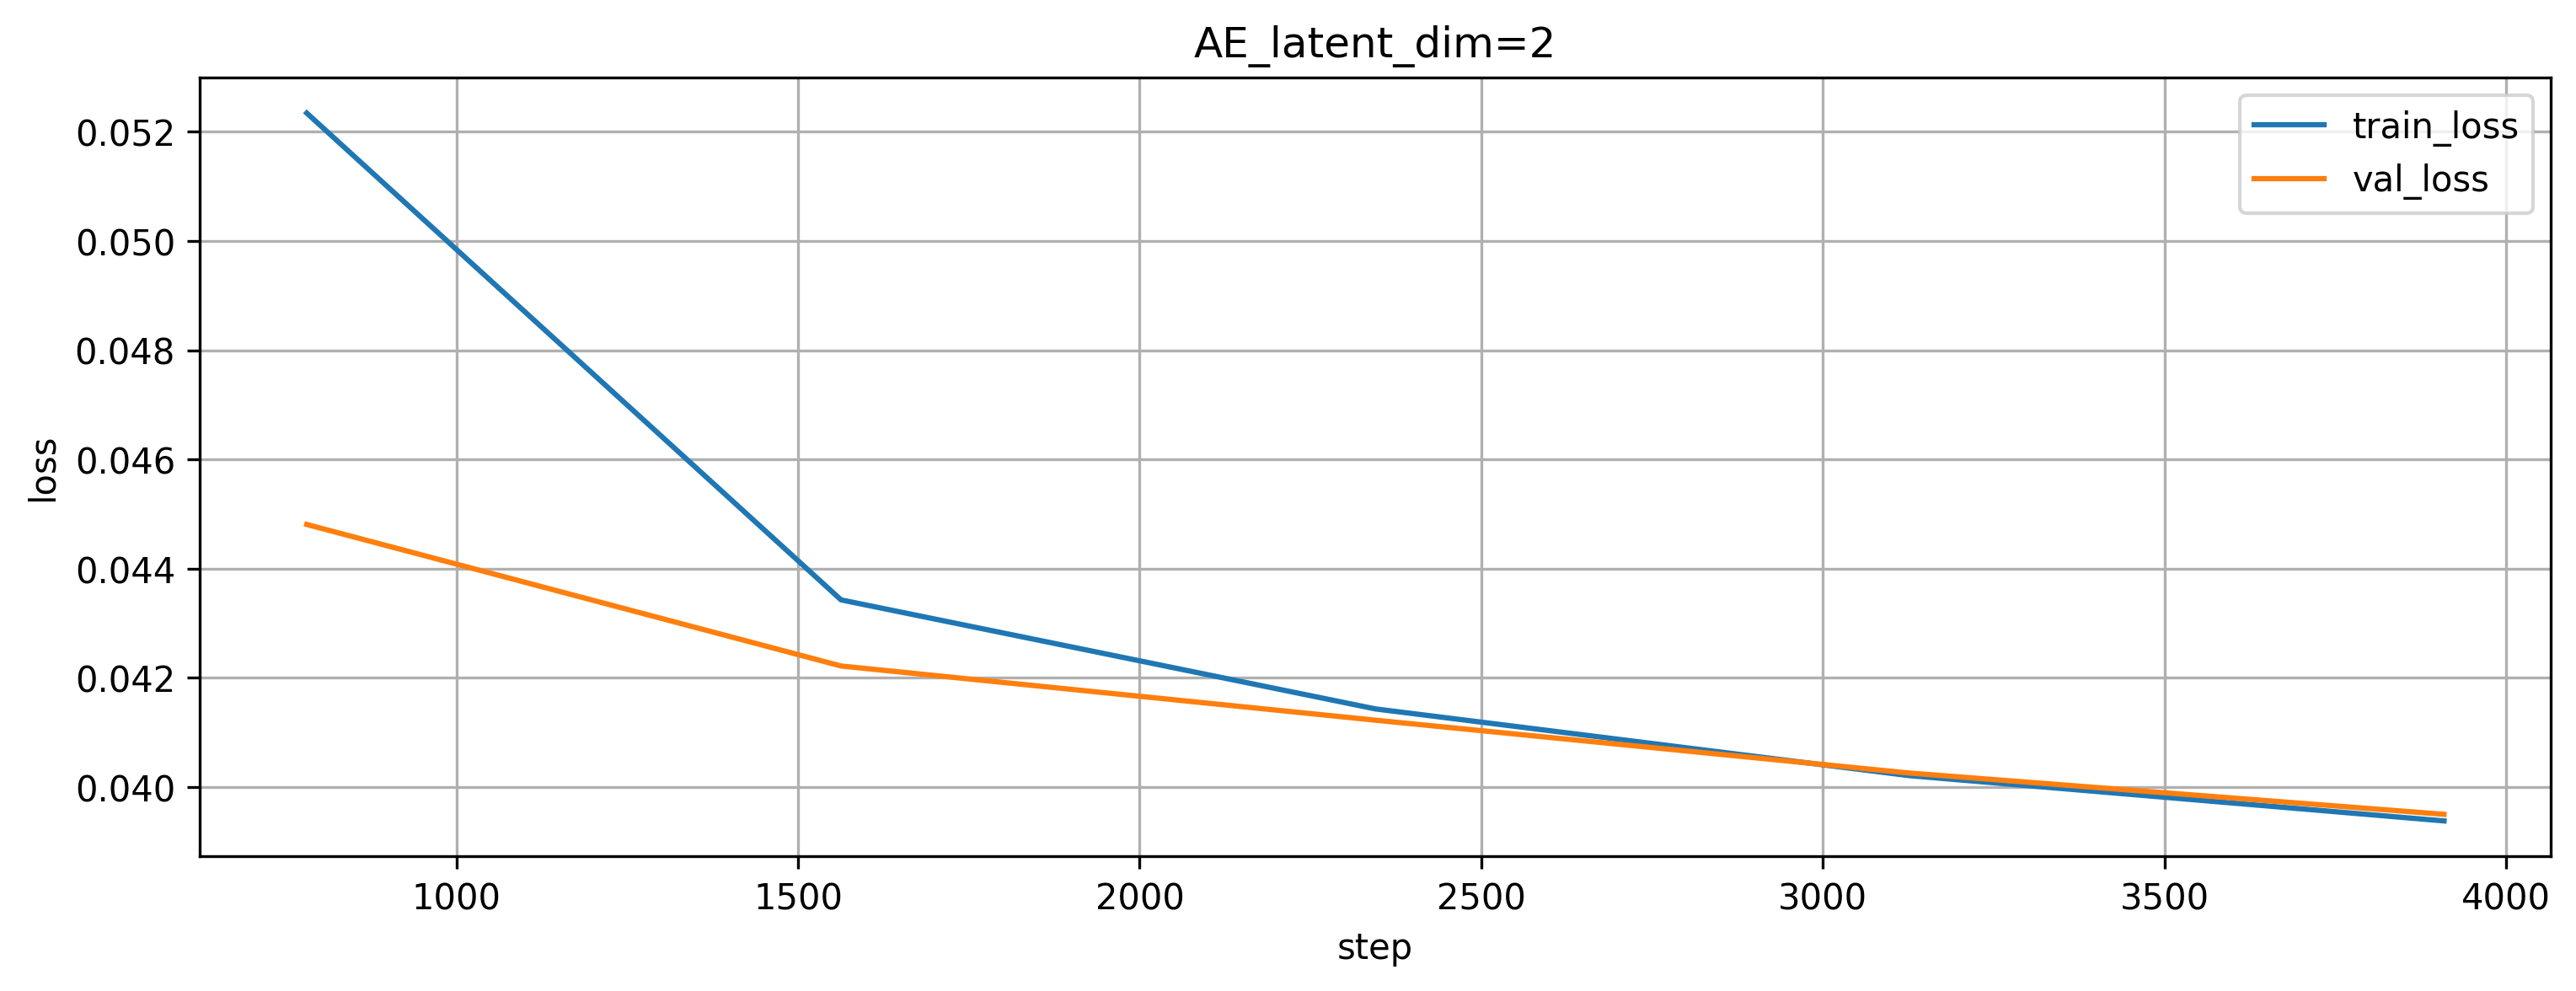

In [17]:
import os

base_path = f"lightning_logs/{exp_name}"
last_version = sorted(os.listdir(base_path))[-1]
log_path = f"{base_path}/{last_version}"

tbparse_visual(log_path, title=exp_name)

### Inference

Kiểm tra mô hình trên dữ liệu test. Kết quả là mô hình `autoencoder` sẽ có một dictionary `test_result`

In [18]:
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result

Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.96it/s]


Khả năng tái tạo dữ liệu của autoencoder

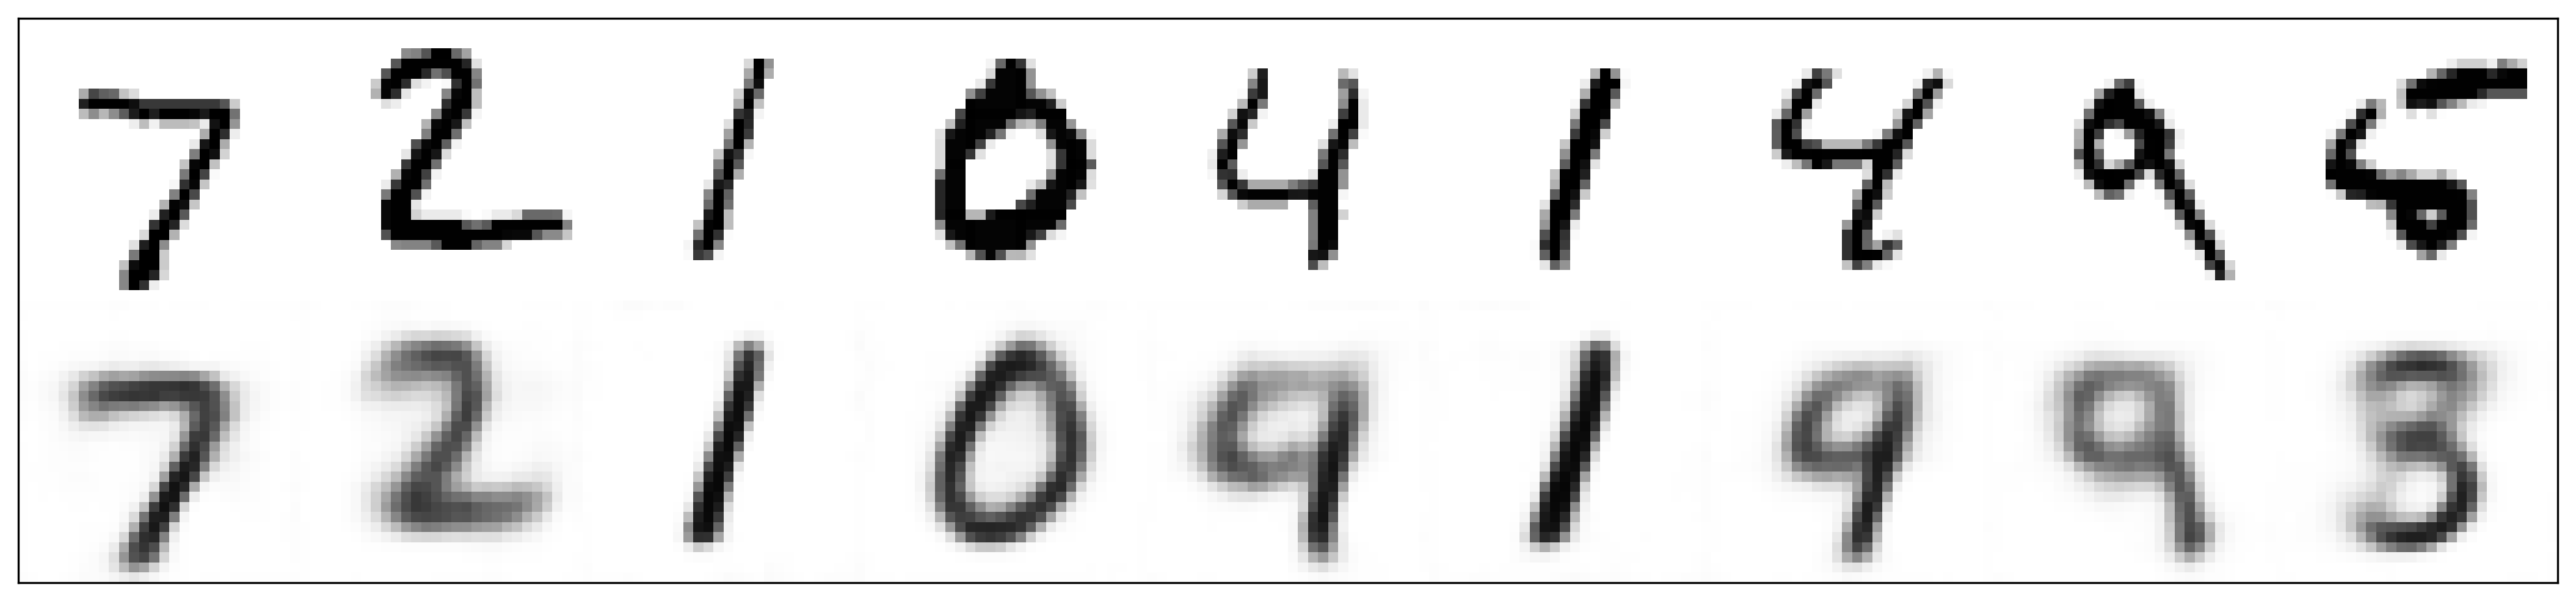

In [19]:
def plot_samples(*args, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()
    

plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

biểu diễn tiềm ẩn (latent representation) mà mô hình đã học được

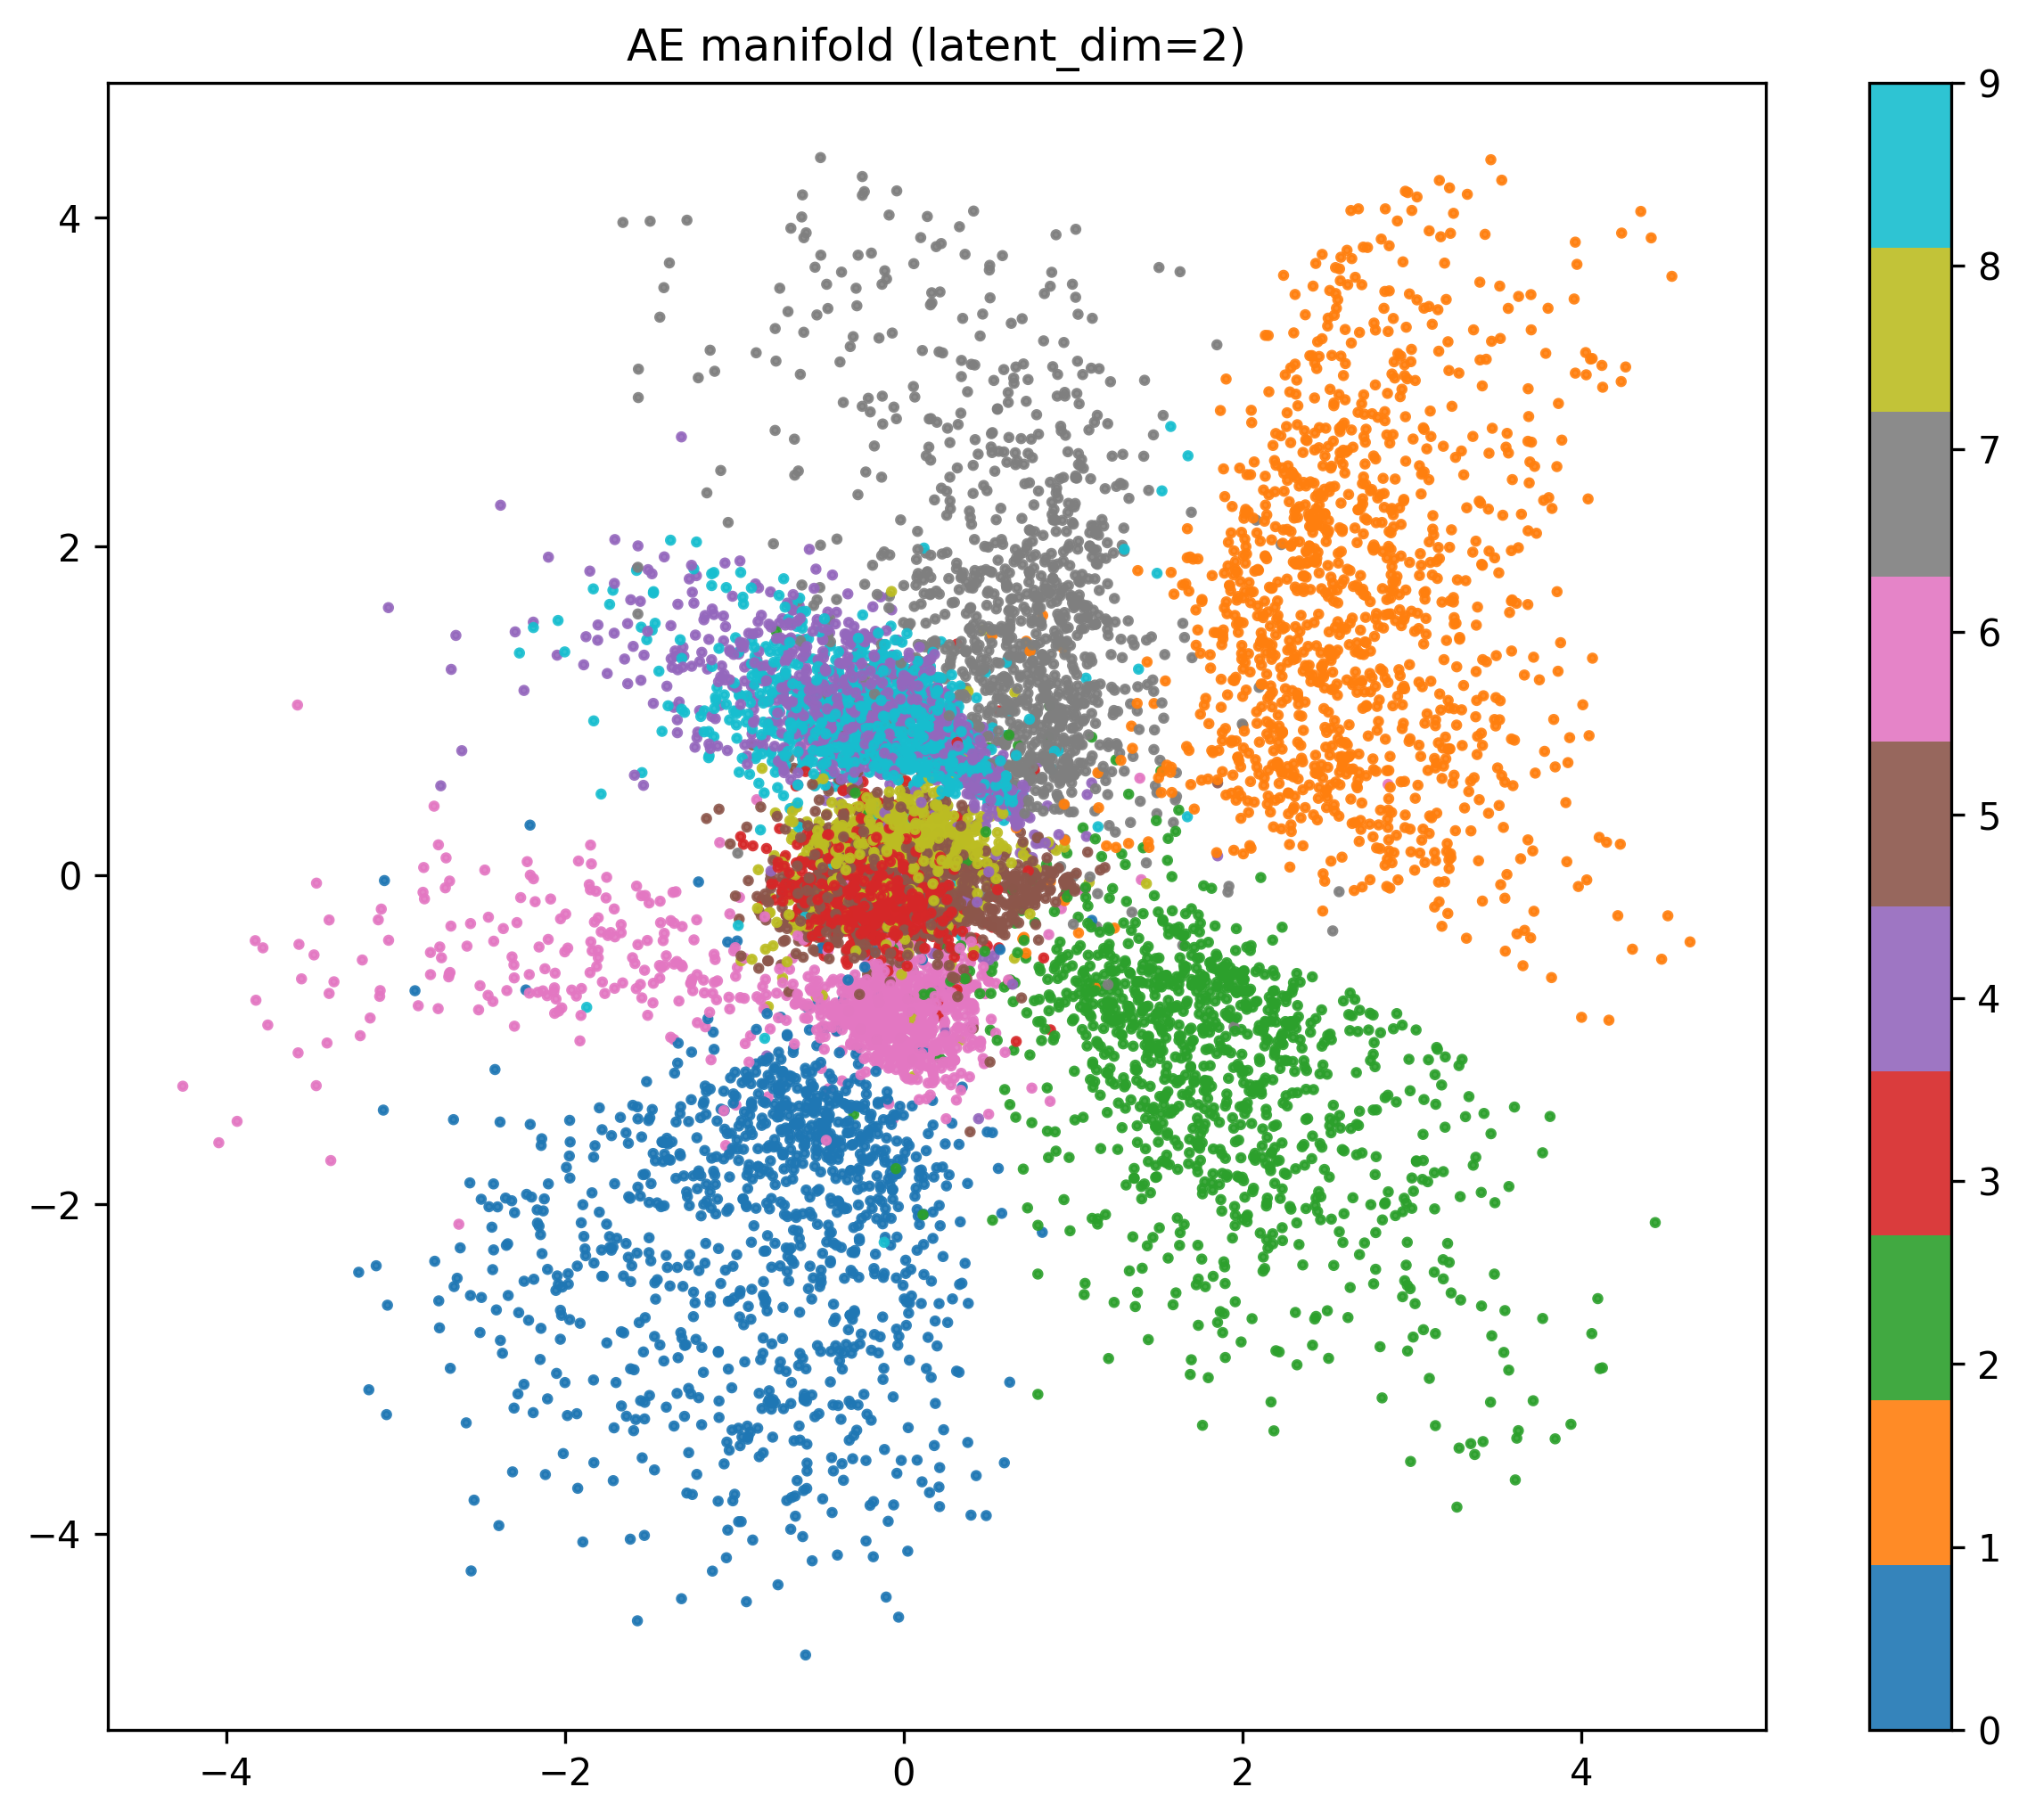

In [20]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 8))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], alpha=alpha, s=4)
    else:
        plt.scatter(
            latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha, s=4
        )
        plt.colorbar()

    if title:
        plt.title(title)
    plt.show()
    

plot_manifold(run_res["latent"], run_res["labels"], title="AE manifold (latent_dim=2)")

Tiếp tục huấn luyện autoencoder với `latent_dim = 16`

In [21]:
!mkdir lightning_logs/AE_latent_dim=16

In [22]:
L.seed_everything(42)

latent_dim = 16
encoder = Encoder(latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim)

autoencoder = LitAE(encoder, decoder)

exp_name = f"AE_latent_dim={latent_dim}"
logger = TensorBoardLogger(save_dir="lightning_logs", name=exp_name)
trainer = L.Trainer(max_epochs=5, logger=logger)

trainer.fit(autoencoder, train_loader, val_loader)

Seed set to 42
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | encoder | Encoder | 405 K  | train
1 | decoder | Decoder | 405 K  | train
--------------------------------------------
811 K     Trainable params
0         Non-trainable params
811 K     Total params
3.245     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 782/782 [02:49<00:00,  4.62it/s, v_num=0]        

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [02:49<00:00,  4.61it/s, v_num=0]


Testing DataLoader 0: 100%|██████████| 157/157 [00:13<00:00, 11.74it/s]


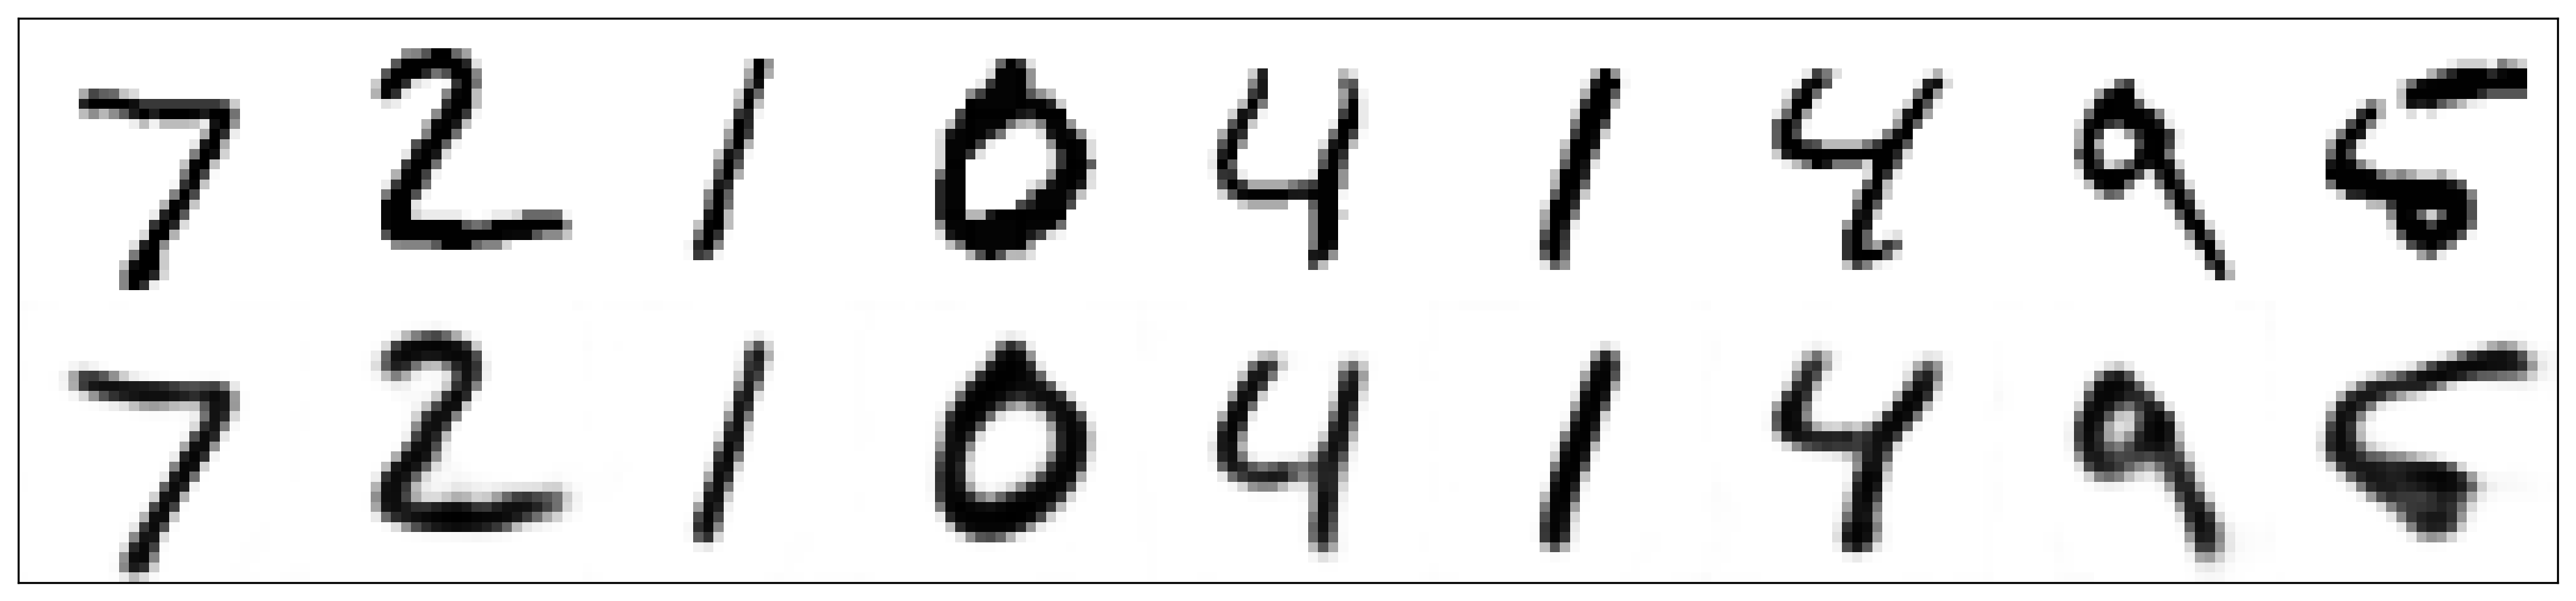

In [23]:
trainer.test(autoencoder, test_loader)
run_res = autoencoder.test_result
plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

Với `latent_dim` có kích thước 16, nhỏ hơn rất nhiều so với số lượng đặc trưng ban đầu (784), chúng ta có thể thấy mô hình đã nén ảnh khá tốt.

### Kiểm tra khả năng xử lý nhiễu của autoencoder

Chúng ta **không** thêm nhiễu trong quá trình huấn luyện. Tạo `DataLoader` và thêm nhiễu vào dữ liệu bằng phép biến đổi.

In [24]:
class AddGaussianNoise:
    def __init__(self, mean=0.0, std=1.0):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f"(mean={self.mean}, std={self.std})"

In [25]:
torch.manual_seed(42)

test_noise_set = MNIST(
    root=root,
    train=False,
    transform=v2.Compose(
        [
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            AddGaussianNoise(0.0, 0.10),
        ]
    ),
    download=True,
)

test_noised_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_noise_set, list(range(64))),
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

Chạy kiểm tra mô hình đã huấn luyện với `latent_dim = 16` trên dữ liệu có nhiễu.


In [26]:
trainer.test(autoencoder, test_noised_loader)
run_res = autoencoder.test_result

Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.28it/s]


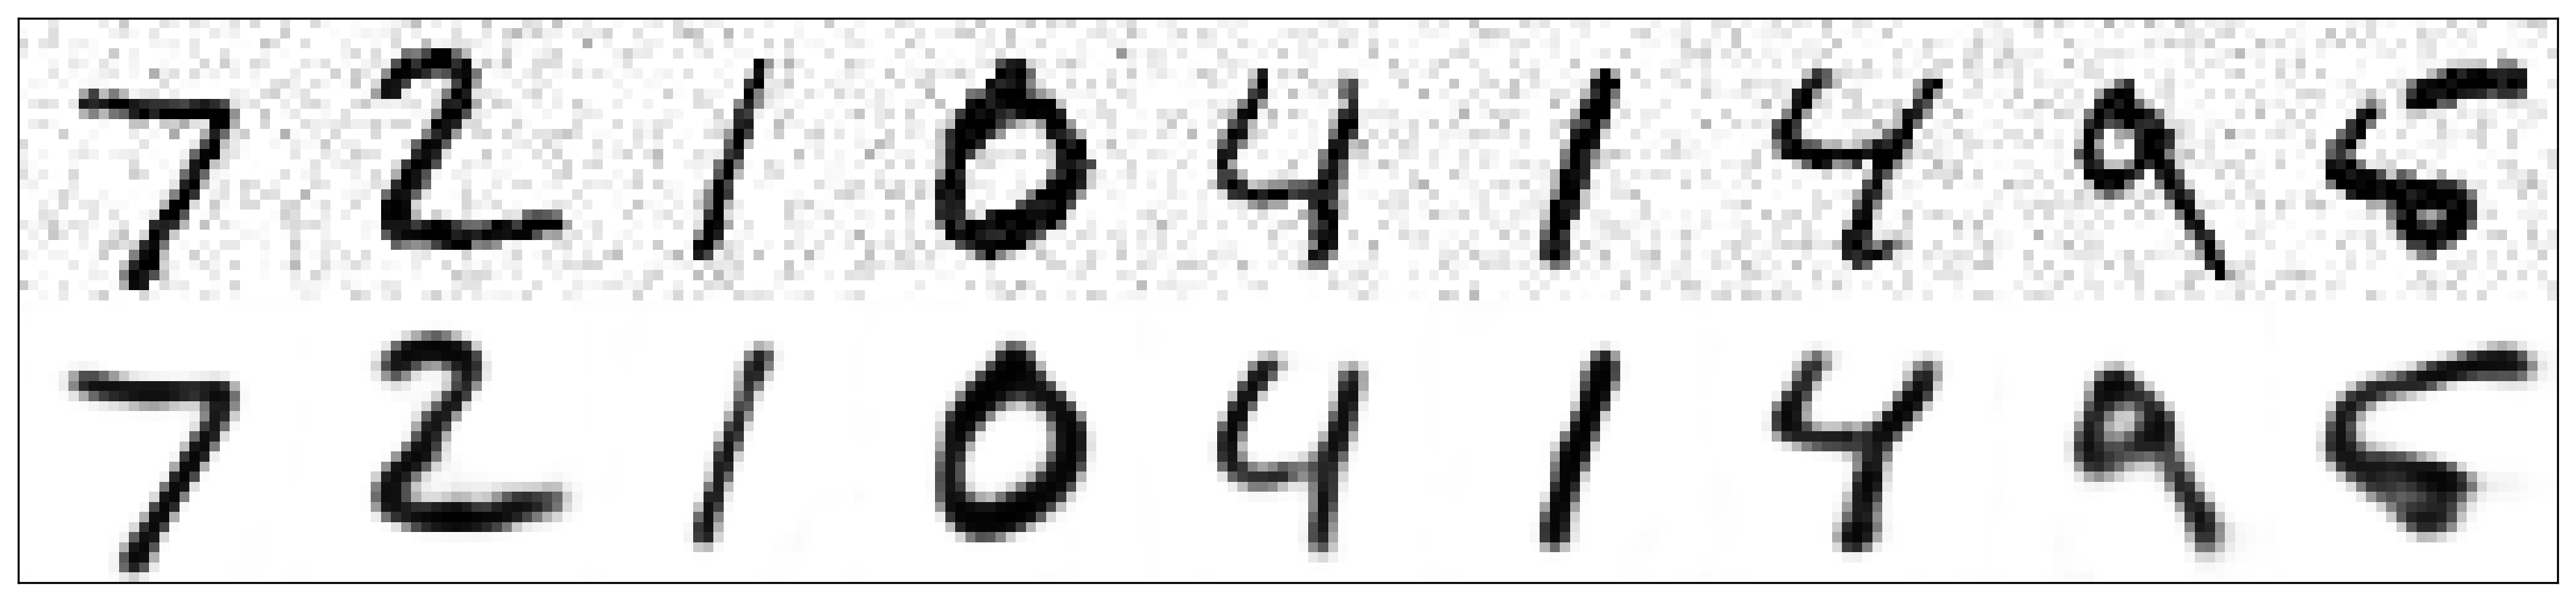

In [27]:
plot_samples(run_res["real"][0:9], run_res["recon"][0:9])

Kết quả cho thấy autoencoder xử lý nhiễu khá tốt — hình ảnh được khôi phục rõ ràng hơn sau khi loại bỏ nhiễu.